## Bayesian Neural Networks: variational inference with epistemic uncertainity, i.e., the Neural Networks who can say "I don't know"

Pi Esposito, AI Software Development Intern @ Intel Corporation

As we are going to work with some non "Kaggle default" packages, you may want to uncomment those pip install for gathering the packages used on this notebook.

In [1]:
#%pip install -U pip
#%pip install tensorflow==2.0
#%pip install tfp-nightly

* **Objective:** 
    This kernel aims to **(i)** justify the **need for Neural Network models which are able to output the uncertainity for its predictions**, i.e., let the Data Scientist know if his model is not able to perform a reliable prediction on the data which he tried to predict the label; and **(ii)** **present the Bayesian approach to Neural Networks** as a way to supply this need.
    
    
* **Note:** In order to ease the explanation of the mathematical part of the BNNs (without any theorethical loss), Neural Networks will be interpreted not as a maximum likelihood estimation for the training data (statistical interpretation), but as and optimized function to model the train data in function of its labels.  


* **Packages used**:
    * TensorFlow 2.0
    * TensorFlow Probability (for probabilistic NN layers)
    * Matplotlib
    * Numpy
    * Pandas
    * Seaborn
    * Sklearn train_test_split function
    * time

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split

%matplotlib inline


/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [3]:
print('TensorFlow version (expected = 2.0.0):', tf.__version__)
print('TensorFlow Probability version (expected = 0.9.0-dev20190912):', tfp.__version__)

TensorFlow version (expected = 2.0.0): 2.0.0-beta1
TensorFlow Probability version (expected = 0.9.0-dev20190912): 0.9.0-dev20190913


* **1. Introduction**
    * 1.1 The "need" for uncertainity gathering on predictions
    * 1.2 The Bayesian approach for Neural Networks
    * 1.3 ELBO loss function
    * 1.4 Notes on TensorFlow 2.0 and TensorFlow Probability 
* **2. Data preparation**
    * 2.1 Load, normalize and reshape data
    * 2.2 Visualizing the data
* **3. Ilustrating the problem with a deterministic CNN**
    * 3.1 Implementing and training the deterministic model
    * 3.2 Predicting on real data and on noise: there is always a prediction
* **4. Implementing a Bayesian Neural Network with TensorFlow 2.0**
    * 4.1 Notes on the implementation
    * 4.2 Implementing the Bayesian model with TFP Layers
    * 4.3 Implementing the ELBO Loss function
    * 4.4 Implementing the train function
    * 4.5 Wrap-up and train the BNN
* **5. Predicting with Monte Carlo methods and epistemic uncertainity gathering**
    * 5.1 Notes on the prediction method
    * 5.2 Gathering the prediction distribution
    * 5.3 Visualizing valid predictions
    * 5.4 Visualizing non-predicted values (noise)
* **6. Conclusion ** 
* **7. References **

## 1. Introduction


## 1.1 The "need" for uncertainity gathering on predictions

Neural Networks do work by performing feedforward and outputing logits, which can be used as predictions or interpreted as wished. 

Despite being very accurate and able to model (with the right hyperparameters) any kind of mathematical function, NNs do operate with any kind of data (if encoded in a tensor according to its input shape). For illustration purposes, it means that, on the case of a image-classifier CNN, once I've encoded an image as a tensor as the same of its input, I'm able to try to predict its label even if my image has nothing to see with my classificator purpose. It also means that, even when I'm trying to predict a very noisy image (which can almos be seen as noise), the network will output a deterministic prediction for it (** see point 3. for illustration**). 

We understand that it would be nice to know how certain our network is of its prediction. For example, in an autonomous car, it should be mandatory to have threshold on which, even if it does not recognize a pedestrian, depending on the uncertanity of its prediction, the car acts as if there was one. This goes for many examples on sensible decisions on which life is involved. 

We also understand that, in some financial cases, (e.g., neural-network consulting stock trader bot) it would also be nice to understand if there is a situation where it is not sure on how to behave and thus stop trading in order to avoid money loss.

**In short, the point is that it would be very beneficial for Deep Learning guided decision process if the neural network could know if it is not trained to understand the data fed on it and output something which can be interpreted as "I'm interpreting this as noise".**[](http://)



#### 1.2 The Bayesian approach for Neural Networks

In order to address that issue, it was created a Bayesian Approach to Neural Networks. It consists on building networks if layer which we will call **proabilistic layers**. This lets gather uncertainity on our predictions, as we will see.

#### Probabilistic layers

Probabilistic layers are neural network layers on which the weights are not deterministic. They are actually **random variables (normally distributed) sampled differently on each feedforward step of the network**. When the layer is being built, for each weight, it randomly starts **mean and standard deviation, which are the trainable parameters**. 

**When the layer is called (i.e., on each feedforward step), it samples a weight from the distribution and runs normally.**

**On the backpropagation step, for each trainable random variable, the gradients are the partial derivative from the Loss in relative the mean and standard deviation**.

This layer-sampling step means that, if we predict many times on the same input, we will have different weights sampled (according to the distribution). Thus, noisy images as prone to have more "uniform-like" distribution, being more sensible to the feature extraction layer changes (as they have no features at all), while real clean images will be less sensible to layer changing and ar prone to keep the same prediction (its label).

To illustrate the feedforward step, we see a  bayesian network on the right side. We see that the bayesian one has a different probability distribution for each weight.

![](https://raw.githubusercontent.com/zackchase/mxnet-the-straight-dope/master/img/bbb_nn_bayes.png)
[Credits for Gluon](https://gluon.mxnet.io/chapter18_variational-methods-and-uncertainty/bayes-by-backprop.html)

#### Uncertanity gathering

To gather uncertanity on our predictions, we use Monte Carlo methods and predict it N times, saving each sampled prediction. We then get the prediction distribution and, using a threshold, decide that, if the mode of the prediction represent less then the threshold, then the network should not decide at all and we do not consider the prediction. Our "reliability" of the predicition the % of the total predictions that the mode represent. 

Real data tend to have the mode representing almost 100%, while the more noisy it is, the more it uniform distribution it will have.


## 1.3 ELBO loss function 


As we are working with Probability distribution, we will use a combination of the KL divergence, which is a mathematical representation of the information loss on representing the labels of the train features-label pair with the feedforward representation with the sparse categorical crossentropy, as is usually done on classification NN modelling.

As TensorFlow lets us calculate each of this losses, won´t have to code it by hand. If you want to know more about the derivatives and the math, I'm putting a link for the original paper on the end of this kernel.

By the way, we call this function the ELBO loss functon, which stants for expected lower bound.
It is defined as:

(The KL Divergence of our predicted distribution relative to the labels plus the crossentropy of our predicted relative to the labels - being Q the predicted probabilities or logits):[](http://)

\begin{equation*}
* \mathcal{L}(\mathcal{D}, \mathbf{\theta}) = \text{KL}[q(\mathbf{w}\ |\ \mathbf{\theta})\ ||\ P(\mathbf{w})] - \mathbb{E}_{q(\mathbf{w}\ |\ \mathbf{\theta})}[\log P(\mathcal{D}\ |\ \mathbf{w})]
\end{equation*}

## 1.4 Notes on TensorFlow 2.0 and TensorFlow probability

First, some useful links:

* [TensorFlow 2.0 quickstart tutorial](https://www.tensorflow.org/tutorials/quickstart/)

* [TensorFlow Probability main page and tutorials](https://www.tensorflow.org/probability)

#### TensorFlow 2.0
##### All the features explained here will be shown during the implementations
* TensorFlow 2.0 has ended tf.Session(), feed_dict and sess.run. We now just have to call the node of the graph to get its value. TensorFlow 2.0 has also ended the need for placeholders, giving us a much more intuitive way to flow tensors thorugh graphs:

* We define it as a funcion with the inputs a parameters. We do the operations and return the nodes we want to. The only thing we have to do is put @tf.function decorator above the definition. We can calculate losses and optimize models with tf.functions in a much easier way.

* For gradient appliying, we have gradientTape which gets the derivative of our last operation relative to all the nodes conected to it, and a powerful and easy way to apply those gradients with the optimizer.



#### TensorFlow Probability

* The probabilistic counterpart os TensorFlow has, on its features, some probabilistic counterparts for layers, so we don't have to bother in implementing probabilistic layers.

* The nightly version of TFP works well with all the TensorFlow 2.0 features, and so it will be very easy to write custom losses and manually optimizing our Bayesian Network on the future.

## 2. Data preparation

## 2.1 Load, normalize and reshape the data

We are using MNIST dataset!
X_train.shape = (60000, 28, 28, 1)
Y_train.shape = (60000, 10)
Y_val.shape = (10000, 28, 28, 1)
Y_val.shape = (10000, 10)


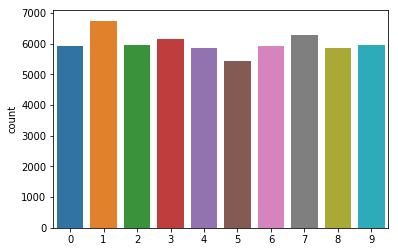

In [4]:
"""
first, we load the dataset. We are trying to do it first with MNIST
I've found this snippet somewhere in github
"""

#as we have 10 classes, I'm setting class number to 10
class_nmr = 10

print('We are using MNIST dataset!')
(X_train, Y_train), (X_val, Y_val) = tf.keras.datasets.mnist.load_data()
g = sns.countplot(Y_train)
X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
X_val = np.expand_dims(X_val, -1)
Y_train = tf.keras.utils.to_categorical(Y_train, class_nmr)
Y_val = tf.keras.utils.to_categorical(Y_val, class_nmr)

# Normalize data
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("Y_train.shape =", Y_train.shape)
print("Y_val.shape =", X_val.shape)
print("Y_val.shape =", Y_val.shape)

#plt.imshow(X_train[1026, :, :, 0], cmap='gist_gray')

As we can see, its almos uniformely distributed, so we're not doing any augmentation

We normalize and reshape our data so we have a train set with shape (N, 28, 28, 1), being N the number of images. We also set our Y_train to categorical and divide our data into a train and test dataset.

## 2.2 Visualize the data

If we want to visualize an image from our dataset, we gather its index and use matplotlib this way:

True label of the test sample 1026: 8


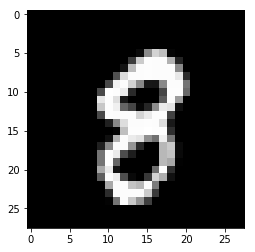

In [5]:
#We are using 1026, as it is my birthday
idx = 1026
plt.imshow(X_train[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(Y_train[idx], axis=-1)))

# 3. Ilustrating the problem with a deterministic CNN

## 3.1 Implementing and training the deterministic model

We will, below, implement a deterministic model for predicting on the MNIST dataset using Keras interface, as there will be no custom function or module.

In [6]:
def build_cnn(input_shape):
    
    ##model building
    model = tf.keras.models.Sequential()
    #convolutional layer with rectified linear unit activation
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    #32 convolution filters used each of size 3x3
    #again
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    #64 convolution filters used each of size 3x3
    #choose the best features via pooling
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    #randomly turn neurons on and off to improve convergence
    model.add(tf.keras.layers.Dropout(0.25))
    #flatten since too many dimensions, we only want a classification output
    model.add(tf.keras.layers.Flatten())
    #fully connected to get all relevant data
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    #one more dropout for convergence' sake :) 
    model.add(tf.keras.layers.Dropout(0.5))
    #output a softmax to squash the matrix into output probabilities
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    return model

In [7]:
#here we build the network, instance an optizmier and compile it
cnn = build_cnn(X_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.01)
cnn.compile(loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'], optimizer=optimizer)

In [8]:
history = cnn.fit(X_train, Y_train, epochs=10, validation_split=0.1)

W1008 14:57:39.039222 139839752634112 deprecation.py:323] From /home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 31s 583us/sample - loss: 0.3100 - accuracy: 0.9074 - val_loss: 0.0769 - val_accuracy: 0.9760
Epoch 2/10
54000/54000 [==============================] - 30s 561us/sample - loss: 0.2092 - accuracy: 0.9382 - val_loss: 0.0822 - val_accuracy: 0.9767
Epoch 3/10
54000/54000 [==============================] - 30s 549us/sample - loss: 0.2056 - accuracy: 0.9410 - val_loss: 0.0763 - val_accuracy: 0.9782
Epoch 4/10
54000/54000 [==============================] - 29s 543us/sample - loss: 0.2009 - accuracy: 0.9434 - val_loss: 0.0665 - val_accuracy: 0.9797
Epoch 5/10
54000/54000 [==============================] - 30s 555us/sample - loss: 0.1986 - accuracy: 0.9444 - val_loss: 0.0673 - val_accuracy: 0.9812
Epoch 6/10
54000/54000 [==============================] - 30s 552us/sample - loss: 0.1944 - accuracy: 0.9457 - val_loss: 0.0792 - val_accuracy: 0.9795
Epoch 7/10
54000/54000 [=====================

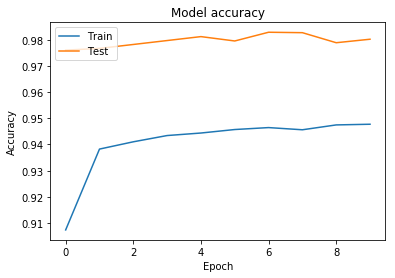

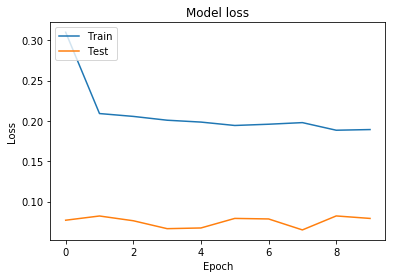

In [9]:
#plotting accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
evaluation = cnn.evaluate(X_val, Y_val, verbose=2)
print(evaluation)

10000/10000 - 1s - loss: 0.0839 - accuracy: 0.9776
[0.08385539886620032, 0.9776]


As we see, we have very good metrics and it did converge very fastly

## 3.2 Predicting on real data and on noise: there is always a prediction

As we are going to see, our neural network will predict outputs, as we see:

For real data:

In [11]:
pred_for_idx = cnn(X_train[idx:idx+1, :, :, :])

Predicted label of the test sample 1026: 8


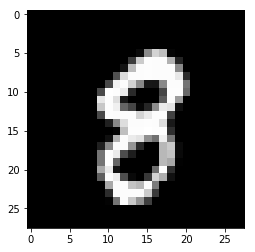

In [12]:
idx = 1026
plt.imshow(X_train[idx, :, :, 0], cmap='gist_gray')
print("Predicted label of the test sample {}: {}".format(idx, np.argmax(pred_for_idx[0]), axis=-1))

For noise generated data:

Predicted label of the test sample 1026: 6


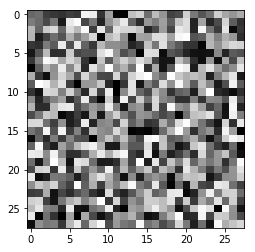

In [14]:
noise = np.random.random((28,28,1))
pred_for_noise = cnn(np.array([noise]).astype(np.float32))
plt.imshow(noise[:, :, 0], cmap='gist_gray')
print("Predicted label of the test sample {}: {}".format(idx, np.argmax(pred_for_noise[0]), axis=-1))


Above we have the illustration of the problem of noise-like data on deterministic Neural Networks: it gains a label and is processed as that, but it does not represent anything. To address this issue, we're implementing the probabilistic network. 

## 4. Implementing a Bayesian Neural Network with TensorFlow 2.0

## 4.1 Notes on the implementation

In order to do our implementation, we are will implement the following functions:
The model will be a keras one, but won't be compiled, as we are wusing TF 2.0 features
* build_bcnn_model: builds a Bayesian Convnet for our MNIST classification;
* elbo_loss: tf.function that calculates elbo_loss for our network
* train_step: tf.function that trains our bcnn model
* accuracy: gets the accuracy of the predictions for plotting

## 4.2 Implementing the Bayesian model with TFP Layers

In [15]:
def build_bayesian_bcnn_model(input_shape):
    
    """
    Here we use tf.keras.Model to use our graph as a Neural Network:
    We select our input node as the net input, and the last node as our output (predict node).
    Note that our model won't be compiled, as we are usign TF2.0 and will optimize it with
    a custom @tf.function for loss and a @tf.function for train_step
    Our input parameter is just the input shape, a tuple, for the input layer
    """
    
    model_in = tf.keras.layers.Input(shape=input_shape)
    conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_1(model_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    conv_2 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_2(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Flatten()(x)
    dense_1 = tfp.python.layers.DenseFlipout(512, activation='relu')
    x = dense_1(x)
    dense_2 = tfp.python.layers.DenseFlipout(10, activation=None)
    model_out = dense_2(x)  # logits
    model = tf.keras.Model(model_in, model_out)
    return model

## 4.3 Implementing the ELBO Loss function

In [16]:
"""
this is our loss function: a sum of KL Divergence and Softmax crossentropy
We use the @tf.function annotation becuase of TF2.0, and need no placeholders
we get each loss and return its mean
"""

@tf.function
def elbo_loss(labels, logits):
    loss_en = tf.nn.softmax_cross_entropy_with_logits(labels, logits)
    loss_kl = tf.keras.losses.KLD(labels, logits)
    loss = tf.reduce_mean(tf.add(loss_en, loss_kl))
    return loss

## 4.4 Implementing the train function

In [17]:
"""
this is our train step with tf2.0, very ellegant:
We do our flow of the tensors over the model recording its gradientes
Then, our gradient tape to give us a list of the gradients of each parameter in relation of the loss
we dan ask our previously instanced optimizer to apply those gradients to the variable
It is cool to see that it works even with TensorFlow probability- probabilistic layers parameters
"""
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = bcnn(X_train)
        loss = elbo_loss(labels, logits)
    gradients = tape.gradient(loss, bcnn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, bcnn.trainable_variables))
    return loss

def accuracy(preds, labels):
    return np.mean(np.argmax(preds, axis=1) == np.argmax(labels, axis=1))

## 4.5 Wrap-up and train the BNN

We will se that our BNN takes mroe time to start converging

In [ ]:
bcnn = build_bayesian_bcnn_model(X_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.01)

In [ ]:
"""
in our train step we can see that it lasts more tha na normal CNN to converge
on the other side, we can have the confidence interval for our predictions, which are 
wonderful in terms of taking sensitive predictions
"""
times = []
accs = []
val_accs = []
losses = []
val_losses = []
for i in range(20):
    tic = time.time()
    loss = train_step(X_train, Y_train)
    preds = bcnn(X_train)
    acc = accuracy(preds, Y_train)
    accs.append(acc)
    losses.append(loss)
    
    val_preds = bcnn(X_val)
    val_loss = elbo_loss(Y_val, val_preds)
    val_acc = accuracy(Y_val, val_preds)
    
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    tac = time.time()
    train_time = tac-tic
    times.append(train_time)
    
    print("Epoch: {}: loss = {:7.3f} , accuracy = {:7.3f}, val_loss = {:7.3f}, val_acc={:7.3f} time: {:7.3f}".format(i, loss, acc, val_loss, val_acc, train_time))

### Accuracy and loss evolution:

Some metrics to illustrate its evolution. We can see from the logs above that our BNN is generalizing very well on the validation set. On the other side, it lasts much more to train.

In [ ]:
#plotting accuracy
plt.plot(np.array(accs), label="acc")
plt.plot(np.array(val_accs), label="val_acc")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Plot training & validation loss values
plt.plot(np.array(losses), label="loss")
plt.plot(np.array(val_losses), label="val_loss")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 5. Predicting with Monte Carlo methods and epistemic uncertainity gathering

## 5.1 Notes on the prediction method

We will now use our trained Bayesian Neural Network to predict on labeled real values and noisy ones. Our approach will consist in sampling 30 predictions for each value, then see the prediction distribution. The neural network will be set to "I don't know" if it cant predict, with confidence, any value. To predict a value, using the montecarlo method, the median of the labels predicted probability must surpass 0.35.

We want to show that, the more the sampled networks predict on the mode prediction, the more reliable the prediction will be. On the other side, "confuse" and uncertain predictions will have the predictions distributed on more labels, approximating to a uniform distribution.

In order to to that, we are implementing functions to gather and plot those distributions.
    

### Plot prediction histogram function:

The function below plots the histograms for each label probabilities prediction and will be used to visualize our data. This function was mostly from Zhullingchen GitHub (with minor changes).

Here is the link of the repo, which I strongly recomend you give a look: [TFP tutorial from Zhulingchen](https://github.com/zhulingchen/tfp-tutorial/)

In [11]:
def plot_pred_hist(y_pred, n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=2, figsize=(25, 10)):
    bins = np.logspace(-n_bins, 0, n_bins+1)
    fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=figsize)
    for i in range(n_subplot_rows):
        for j in range(n_class // n_subplot_rows + 1):
            idx = i * (n_class // n_subplot_rows + 1) + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median probability: {:.2f}) ({})".format(str(idx),
                                                                               np.median(y_pred[idx]),
                                                                               str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    plt.show()

## 5.2 Gathering the prediction distribution

On the snippet below, we just apply the Monte Carlo technique to sample and predict labels 30 times for each image on the validation set. We then store those predictions on lists to plot the distribution and gather insights.

In [12]:
n_mc_run = 50
med_prob_thres = 0.35

y_pred_logits_list = [bcnn(X_val) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([tf.nn.softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(Y_val[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(Y_val[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(Y_val[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(Y_val[idx_invalid]))

NameError: name 'bcnn' is not defined

## 5.3 Visualizing valid predictions
    

In [13]:
Here we just visualize some well predicted values.

SyntaxError: invalid syntax (<ipython-input-13-955576560ae7>, line 1)

In [ ]:
plt.imshow(X_val[0, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(0, np.argmax(Y_val[0], axis=-1)))

plot_pred_hist(y_pred_prob_all[0], class_nmr, n_mc_run, med_prob_thres=med_prob_thres)

## 5.4 Visualizing non-predicted values
    

On this snippet we do visualize the noisy images which the network is not able to predict on properly.

In [ ]:
for idx in np.where(idx_invalid)[0]:
    plt.imshow(X_val[idx, :, :, 0], cmap='gist_gray')
    print("True label of the test sample {}: {}".format(idx, np.argmax(Y_val[idx], axis=-1)))

    plot_pred_hist(y_pred_prob_all[idx], class_nmr, n_mc_run, med_prob_thres=med_prob_thres)

    if any(y_pred[idx]):
        print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
    else:
        print("I don't know!")

## 6. Conclusion 

As a conclusion, we found that 
1.  Bayesian Neural Networks may be more reliable than the deterministic ones;
2.  For sensible decision taking, it may be the more "ethical approach", due to the possibility of avoiding taking risky decision which the model is not trained to predict;
3.  Bayesian Networks are more prone to avoid overfitting, due to the weights uncertainity;
4.  On the other side, Bayesian Networks do last more to train and to start having some good accuracy on which we can rely on.

## 7. References and material if you want to know more
* [Gluon BNN tutorial](https://gluon.mxnet.io/chapter18_variational-methods-and-uncertainty/bayes-by-backprop.html)

* [Weight Uncertainty in Neural Networks](https://arxiv.org/pdf/1505.05424.pdf)

* [TensorFlow 2.0 quickstart tutorial](https://www.tensorflow.org/tutorials/quickstart/)

* [TensorFlow Probability main page and tutorials](https://www.tensorflow.org/probability)

* [An excelent TFP tutorial from Zhulingchen](https://github.com/zhulingchen/tfp-tutorial/)

* [My github repo with the implementetion (in case you want to run it on your local machine)](https://github.com/piEsposito/easy-bnn-with-tf2.0)
